In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn import linear_model
import numpy as np
import time
import sys
from sklearn.model_selection import train_test_split
import scipy
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from string import digits
import re
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt
import os;

In [2]:
import nltk

nltk.download('punkt')
nltk.download('popular')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    | 

True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/University/datasets2020/datasets/q2b/train.csv")
df.head()

,Id,Question1,Question2,IsDuplicate
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
df_test = pd.read_csv("/content/drive/MyDrive/University/datasets2020/datasets/q2b/test_without_labels.csv")
df_test.head()

,Id,Question1,Question2
0,283003,What can someone do if they've lost the wirele...,What is the best USB wireless mouse that can b...
1,283004,Why India need to elect Prime minister?,Is prime minister of India elected or appointed?
2,283005,How can I make money online with free of cost?,How can I make money online for free?
3,283006,Does MDMA affect the first and higher order mo...,Do antipsychotics affect the first and higher ...
4,283007,"I am a Saudi National and have ""SR 3 million"" ...",Where should I invest money to get high returns?


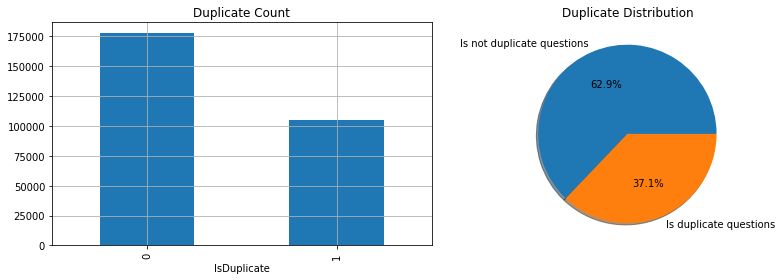

In [7]:
# Bar chart
plt.subplot(1, 2, 1)
df.groupby('IsDuplicate')['Id'].count().plot.bar()
plt.grid(True)
plt.title('Duplicate Count')
plt.subplots_adjust(right=1.9)

# Pie Chart
plt.subplot(1, 2, 2)
values = [df[df['IsDuplicate']==0].shape[0], df[df['IsDuplicate']==1].shape[0]]
labels = ['Is not duplicate questions', 'Is duplicate questions']

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title('Duplicate Distribution')
plt.tight_layout()
plt.subplots_adjust(right=1.9)
plt.show()

In [8]:
df[df.isnull().any(axis=1)]

,Id,Question1,Question2,IsDuplicate
105780,105780,How can I develop android app?,NaN,0
201841,201841,How can I create an Android app?,NaN,0


In [9]:
df = df.dropna()
df.shape

(283002, 4)

In [10]:
qids = pd.Series((df['Question1'].astype(str)).tolist() + (df['Question2'].astype(str)).tolist())
uniq = len(np.unique(qids))
print('Total number of unique questions is {}'.format(uniq))
#Number of questions that repeated than 1 time
cnt = qids.value_counts()
more1 = len(cnt[cnt.values > 1])
print('Number of questions that repeated more than 1 time is {} which is {}%'.format(more1,(more1/(len(cnt))*100)))
print('The maximum number of times a question occured is {}'.format(max(cnt)))

Total number of unique questions is 402690
Number of questions that repeated more than 1 time is 73402 which is 18.22791725645037%
The maximum number of times a question occured is 112


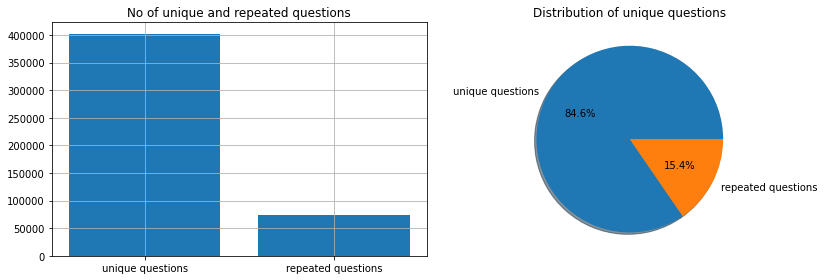

In [11]:
x = ['unique questions','repeated questions']
y = [uniq,more1]
plt.subplot(1, 2, 1)
plt.bar(x,y)
plt.grid(True)
plt.title('No of unique and repeated questions')
plt.subplots_adjust(right=1.9)

# Pie Chart
plt.subplot(1, 2, 2)
plt.pie(y, labels=x, autopct='%1.1f%%', shadow=True)
plt.title('Distribution of unique questions')
plt.tight_layout()
plt.subplots_adjust(right=1.9)
plt.show()

## **Feature Extraction**

In [13]:
if os.path.isfile('/content/not_preprocessed_data.csv'):
    data = pd.read_csv("/content/not_preprocessed_data.csv",encoding='latin-1')
else:
    def common_wrd(row):
        x = set(row['Question1'].lower().strip().split(" ")) 
        y = set(row['Question2'].lower().strip().split(" "))
        return 1.0 * len(x & y)


    def total(row):
        set1 = set(row['Question1'].lower().strip().split(" "))
        set2 = set(row['Question2'].lower().strip().split(" "))
        return 1.0 * (len(set1) + len(set2))

    def word_share(row):
        x = float(row['word_common'])/float(row['word_total'])
        return  x

############################################
    
    df['q1len'] = (df['Question1'].astype(str)).apply(lambda x: len(x))
    df['q2len'] = (df['Question2'].astype(str)).apply(lambda x: len(x))
    df['q1_n_words'] = (df['Question1'].astype(str)).apply(lambda x: len(x.split(" ")))
    df['q2_n_words'] = (df['Question2'].astype(str)).apply(lambda x: len(x.split(" ")))
    df['q1_n_stopwords'] = df['Question1'].apply(lambda x: len([c for c in str(x).lower().split() if c in stopwords.words('english')]))
    df['q2_n_stopwords'] = df['Question2'].apply(lambda x: len([c for c in str(x).lower().split() if c in stopwords.words('english')]))
    df['word_common'] = (df.astype(str)).apply(common_wrd,axis=1)
    df['word_total'] = (df.astype(str)).apply(total,axis=1)
    df['word_share'] = (df.astype(str)).apply(word_share,axis=1)
    df.to_csv("data_with_out_preprocess.csv", index=False)
    display(df)

,Id,Question1,Question2,IsDuplicate,q1len,q2len,q1_n_words,q2_n_words,q1_n_stopwords,q2_n_stopwords,word_common,word_total,word_share
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,7,6,10.0,23.0,0.434783
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4,4,4.0,20.0,0.200000
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,8,5,4.0,24.0,0.166667
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,7,4,0.0,19.0,0.000000
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,3,2,2.0,20.0,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
282999,282999,What is the highest gallantry award in India?,India's PM Mr Modi has polled highest votes fr...,0,45,146,8,27,4,10,3.0,35.0,0.085714
283000,283000,Who are your favorite Quorans?,Who are some of your favorite Quorans and why?,1,30,46,5,9,3,6,4.0,14.0,0.285714
283001,283001,What is the best way to add your websites back...,What is the best way to add your websites back...,0,60,60,12,12,6,6,11.0,24.0,0.458333
283002,283002,How old is too old to start medical school?,What age is too old to get a medical MD?,1,43,40,9,10,4,5,5.0,18.0,0.277778


In [14]:
    df_test['q1len'] = (df_test['Question1'].astype(str)).apply(lambda x: len(x))
    df_test['q2len'] = (df_test['Question2'].astype(str)).apply(lambda x: len(x))
    df_test['q1_n_words'] = (df_test['Question1'].astype(str)).apply(lambda x: len(x.split(" ")))
    df_test['q2_n_words'] = (df_test['Question2'].astype(str)).apply(lambda x: len(x.split(" ")))
    df_test['q1_n_stopwords'] = df_test['Question1'].apply(lambda x: len([c for c in str(x).lower().split() if c in stopwords.words('english')]))
    df_test['q2_n_stopwords'] = df_test['Question2'].apply(lambda x: len([c for c in str(x).lower().split() if c in stopwords.words('english')]))
    df_test['word_common'] = (df_test.astype(str)).apply(common_wrd,axis=1)
    df_test['word_total'] = (df_test.astype(str)).apply(total,axis=1)
    df_test['word_share'] = (df_test.astype(str)).apply(word_share,axis=1)
    df_test.to_csv("test_data_with_out_preprocess.csv", index=False)
    display(df_test)

,Id,Question1,Question2,q1len,q2len,q1_n_words,q2_n_words,q1_n_stopwords,q2_n_stopwords,word_common,word_total,word_share
0,283003,What can someone do if they've lost the wirele...,What is the best USB wireless mouse that can b...,100,77,17,18,8,11,6.0,34.0,0.176471
1,283004,Why India need to elect Prime minister?,Is prime minister of India elected or appointed?,39,48,7,8,2,3,2.0,15.0,0.133333
2,283005,How can I make money online with free of cost?,How can I make money online for free?,46,37,10,8,5,4,6.0,18.0,0.333333
3,283006,Does MDMA affect the first and higher order mo...,Do antipsychotics affect the first and higher ...,113,121,18,18,5,5,16.0,36.0,0.444444
4,283007,"I am a Saudi National and have ""SR 3 million"" ...",Where should I invest money to get high returns?,148,48,29,9,13,4,3.0,37.0,0.081081
...,...,...,...,...,...,...,...,...,...,...,...,...
121282,404285,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,85,79,14,13,7,6,11.0,25.0,0.440000
121283,404286,Do you believe there is life after death?,Is it true that there is life after death?,41,42,8,9,5,6,5.0,16.0,0.312500
121284,404287,What is one coin?,What's this coin?,17,17,4,3,2,1,1.0,7.0,0.142857
121285,404288,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,94,127,17,25,8,12,1.0,40.0,0.025000


**Shared words**

We xan see below that the shared words increase significantly when the questions are similar. This can be considered as a rise in the probability of two questions being similar, if they share some same words.

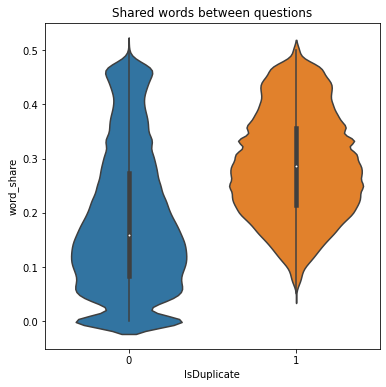

In [15]:
plt.figure(figsize=(6,6))
sns.violinplot(x='IsDuplicate',y='word_share',data=df)
plt.title('Shared words between questions')
plt.show()

**Word commoness** 

In contrast to the shared words depicted in tthe graph above, we see that the common words between the two questions we compare, seem to be overlapping in both true duplicate questions and non duplicate. Thus, we can not extract any information from this particular feature.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


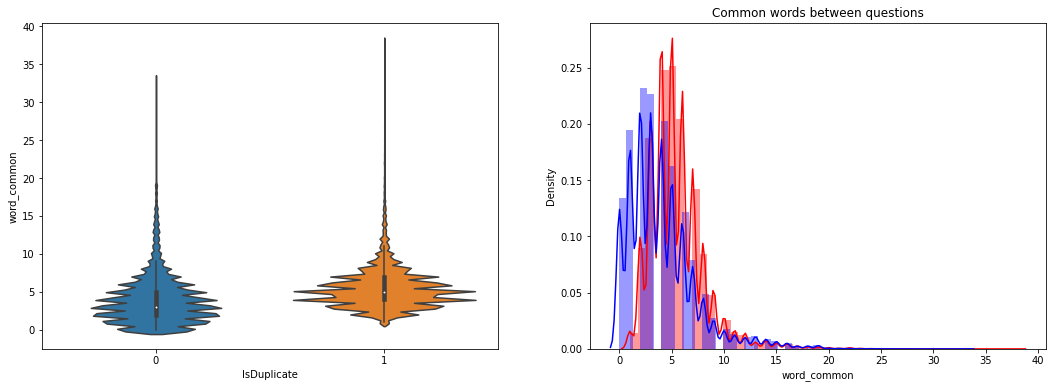

In [16]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.violinplot(x='IsDuplicate',y='word_common',data=df)
plt.subplot(1,2,2)
sns.distplot(df[df['IsDuplicate'] == 1]['word_common'],color='red',label='similar')
sns.distplot(df[df['IsDuplicate'] == 0]['word_common'],color='blue',label='disimilar')
plt.title('Common words between questions')
plt.show()

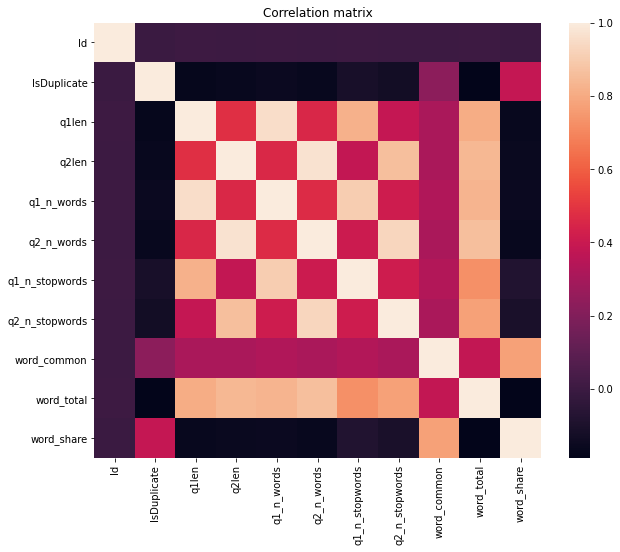

In [18]:
# Correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, ax=ax)
plt.title("Correlation matrix")
plt.show()

In [19]:
def getBOW(df, min_df = 100,ngrams = 1,analyzer = 'word'):
  # bag of letter sequences (chars)
  """
  BOW = TfidfVectorizer(min_df = min_df, analyzer=analyzer, ngram_range=(1,ngrams), lowercase=True)
  """
#max_features=10000,
  BOW = TfidfVectorizer( ngram_range=(1,ngrams), lowercase=True, stop_words=stopwords.words('english'))

  bow_df = pd.DataFrame(pd.concat((df['Question1'],df['Question2'])).unique(), columns=['Concatenated'])

  BOW.fit(bow_df['Concatenated'].values.astype('U'))
  print('Vocabulary size is {}'.format(len(BOW.vocabulary_)))
  return BOW

In [20]:
def shallow_cleaning(df):
  remove_digits = str.maketrans('', '', digits)
  df['Question1'] = pd.DataFrame(df['Question1'].astype(str)).replace('[^\w\s]', '')
  df['Question1'] = pd.DataFrame(df['Question1'].str.strip())
  df['Question1'] = pd.DataFrame(df['Question1'].str.lower())
  df['Question1'] = pd.DataFrame(df['Question1'].str.split())

  df['Question2'] = pd.DataFrame(df['Question2'].astype(str)).replace('[^\w\s]', ' ')
  df['Question2'] = pd.DataFrame(df['Question2'].str.strip())
  df['Question2'] = pd.DataFrame(df['Question2'].str.lower())
  df['Question2'] = pd.DataFrame(df['Question2'].str.split())
  return df

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

def stem(df):
  porter = PorterStemmer()
  df['Question1'] = (df['Question1'].astype(str)).apply(lambda x: word_tokenize(x))
  df['Question1'] = df['Question1'].apply(lambda x: [porter.stem(word) for word in x])
  df['Question1'] = df['Question1'].apply(lambda x: ' '.join(str(word) for word in x))

  df['Question2'] = (df['Question2'].astype(str)).apply(lambda x: word_tokenize(x))
  df['Question2'] = df['Question2'].apply(lambda x: [porter.stem(word) for word in x])
  df['Question2'] = df['Question2'].apply(lambda x: ' '.join(str(word) for word in x))
  return df


In [ ]:
df = pd.read_csv("/content/data_with_out_preprocess.csv")
df.head() 

,Id,Question1,Question2,IsDuplicate,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,q1_n_stopwords,q2_n_stopwords
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10.0,23.0,0.434783,7,6
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4.0,20.0,0.200000,4,4
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4.0,24.0,0.166667,8,5
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.0,19.0,0.000000,7,4
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,2.0,20.0,0.100000,3,2


In [ ]:
df_test = pd.read_csv("/content/test_data_with_out_preprocess.csv")
df_test.head() 

,Id,Question1,Question2,q1len,q2len,q1_n_words,q2_n_words,q1_n_stopwords,q2_n_stopwords,word_common,word_total,word_share
0,283003,What can someone do if they've lost the wirele...,What is the best USB wireless mouse that can b...,100,77,17,18,8,11,6.0,34.0,0.176471
1,283004,Why India need to elect Prime minister?,Is prime minister of India elected or appointed?,39,48,7,8,2,3,2.0,15.0,0.133333
2,283005,How can I make money online with free of cost?,How can I make money online for free?,46,37,10,8,5,4,6.0,18.0,0.333333
3,283006,Does MDMA affect the first and higher order mo...,Do antipsychotics affect the first and higher ...,113,121,18,18,5,5,16.0,36.0,0.444444
4,283007,"I am a Saudi National and have ""SR 3 million"" ...",Where should I invest money to get high returns?,148,48,29,9,13,4,3.0,37.0,0.081081


In [21]:
df = shallow_cleaning(df)
df_test = shallow_cleaning(df_test)

In [22]:
df = stem(df)
df_test = stem(df_test)

In [23]:
df_test.to_csv("data_processed.csv", index=False)
df_test.to_csv("test_data_processed.csv", index=False)

In [24]:
def create_file(data, prediction, filename):
  res_df = pd.DataFrame(data)
  res_df['Predicted'] = prediction
  res_df.to_csv(filename+".csv", columns=['Id', 'Predicted'], index=False)
  return res_df

res_mean = pd.DataFrame([])
res_mean = res_mean.rename_axis('Statistic Measure', axis=1)
columnNum=0
def calculate_statistic_metrics(res, res_mean, columnName, columnNum):
  temp_df = pd.DataFrame([])
  accuracy_mean = pd.Series(res['test_accuracy'].mean(), name='Accuracy')
  precision_mean = pd.Series(res['test_precision_macro'].mean(), name='Precision')
  recall_mean = pd.Series(res['test_recall_macro'].mean(), name='Recall')
  F1_mean = pd.Series(res['test_f1_macro'].mean(), name='F-measure')
  temp_df = temp_df.append(accuracy_mean)
  temp_df = temp_df.append(precision_mean)
  temp_df = temp_df.append(recall_mean)
  temp_df = temp_df.append(F1_mean)
  res_mean[columnName] = temp_df[0]
  res_mean = res_mean.rename(columns={columnNum:columnName})
  return res_mean

In [25]:
# Standardize stats features
from sklearn.preprocessing import StandardScaler

# question length
num_words =  StandardScaler()
X_train_num_words_q1 = num_words.fit_transform(df['q1len'].values.reshape(-1, 1))
X_train_num_words_q2 = num_words.fit_transform(df['q2len'].values.reshape(-1, 1))
X_test_num_words_q1 = num_words.transform(df_test['q1len'].values.reshape(-1, 1))
X_test_num_words_q2 = num_words.transform(df_test['q2len'].values.reshape(-1, 1))


# number of unique words
num_unique_words =  StandardScaler()
X_train_num_unique_words_q1 = num_unique_words.fit_transform(df['q1_n_words'].values.reshape(-1, 1))
X_train_num_unique_words_q2 = num_unique_words.fit_transform(df['q2_n_words'].values.reshape(-1, 1))
X_test_num_unique_words_q1 = num_unique_words.transform(df_test['q1_n_words'].values.reshape(-1, 1))
X_test_num_unique_words_q2 = num_unique_words.transform(df_test['q2_n_words'].values.reshape(-1, 1))


# common words
num_char =  StandardScaler()
X_train_word_common = num_char.fit_transform(df['word_common'].values.reshape(-1, 1))
X_test_word_common = num_char.transform(df_test['word_common'].values.reshape(-1, 1))

# total words
num_char =  StandardScaler()
X_train_word_total = num_char.fit_transform(df['word_total'].values.reshape(-1, 1))
X_test_word_total = num_char.transform(df_test['word_total'].values.reshape(-1, 1))

# shared words
num_char =  StandardScaler()
X_train_word_share = num_char.fit_transform(df['word_share'].values.reshape(-1, 1))
X_test_word_share = num_char.transform(df_test['word_share'].values.reshape(-1, 1))

# number of stopwords
num_stopwords =  StandardScaler()
X_train_num_stopwords_q1 = num_stopwords.fit_transform(df['q1_n_stopwords'].values.reshape(-1, 1))
X_train_num_stopwords_q2 = num_stopwords.fit_transform(df['q2_n_stopwords'].values.reshape(-1, 1))
X_test_num_stopwords_q1 = num_stopwords.transform(df_test['q1_n_stopwords'].values.reshape(-1, 1))
X_test_num_stopwords_q2 = num_stopwords.transform(df_test['q2_n_stopwords'].values.reshape(-1, 1))

print()


In [26]:
print(X_train_num_stopwords_q1.shape, X_train_num_stopwords_q2.shape)
print(X_train_num_unique_words_q1.shape, X_train_num_unique_words_q2.shape)
print(X_train_num_words_q1.shape, X_train_num_words_q2.shape)
print(X_train_word_common.shape)
print(X_train_word_total.shape)
print(X_train_word_share.shape)

(283002, 1) (283002, 1)
(283002, 1) (283002, 1)
(283002, 1) (283002, 1)
(283002, 1)
(283002, 1)
(283002, 1)


**Logistic Regression**

In [27]:
def train_params(min_df = 100,ngrams = 1,analyzer = 'word',train = df, test=df_test):
  start_time = time.time()
  print('BOW and logistic regression')
  BOW = getBOW(train, min_df=min_df,ngrams = ngrams,analyzer = analyzer)
  trainq1_trans = BOW.transform(train['Question1'].values.astype('U'))
  trainq2_trans = BOW.transform(train['Question2'].values.astype('U'))
  labels = train['IsDuplicate'].values

  print(trainq1_trans.shape, trainq2_trans.shape)

  # Stacking features 

  X = scipy.sparse.hstack((
      trainq1_trans,
      trainq2_trans,
      X_train_num_words_q1,
      X_train_num_words_q2,
      X_train_num_unique_words_q1,
      X_train_num_unique_words_q2,
      X_train_num_stopwords_q1,
      X_train_num_stopwords_q2,
      X_train_word_share,
      X_train_word_common,
      X_train_word_total,
      
  ))
  print(X.shape, labels.shape)

  y = labels

  model = linear_model.LogisticRegression(n_jobs=4,C=0.5)

  print('5-Fold Cross Validation')
  scoring=['accuracy','precision_macro', 'recall_macro', 'f1_macro']
  scores = cross_validate(model, X, y, cv=5, n_jobs=4, scoring=scoring) 
  lgr_res = pd.DataFrame.from_dict(scores) 
  res = calculate_statistic_metrics(lgr_res, res_mean, 'Logistic Regression', columnNum)
  display(res)        
  
  print('fitting ...')
  model.fit(X,y)

  BOW = getBOW(train, min_df=min_df,ngrams = ngrams,analyzer = analyzer)
  testq1_trans = BOW.transform(test['Question1'].values.astype('U'))
  testq2_trans = BOW.transform(test['Question2'].values.astype('U'))
  
  X_test = scipy.sparse.hstack((
    testq1_trans,
    testq2_trans,
    X_test_num_words_q1,
    X_test_num_words_q2,
    X_test_num_unique_words_q1,
    X_test_num_unique_words_q2,
    X_test_num_stopwords_q1,
    X_test_num_stopwords_q2,
    X_test_word_share,
    X_test_word_common,
    X_test_word_total,
  ))
  
  print('predicting ...')
  y_pred = model.predict(X_test)

  lgr_pred_df = create_file(test, y_pred, 'LGR_pred')

  end_time =time.time()
  print("total time elapsed is {}".format(end_time-start_time))

  return 

train_params()

BOW and logistic regression
Vocabulary size is 57887
(283002, 57887) (283002, 57887)
(283002, 115783) (283002,)
5-Fold Cross Validation


Statistic Measure,Logistic Regression
Accuracy,0.778143
Precision,0.764295
Recall,0.753096
F-measure,0.757612


fitting ...
Vocabulary size is 57887
predicting ...
total time elapsed is 78.26466965675354


**Linear SVM**

In [28]:
def train_params(min_df = 100,ngrams = 1,analyzer = 'word',train = df, test = df_test):
  start_time = time.time()
  print('BOW and Linear SVM')
  BOW = getBOW(train, min_df=min_df,ngrams = ngrams,analyzer = analyzer)
  trainq1_trans = BOW.transform(train['Question1'].values.astype('U'))
  trainq2_trans = BOW.transform(train['Question2'].values.astype('U'))
  labels = train['IsDuplicate'].values

  X = scipy.sparse.hstack((
      trainq1_trans,
      trainq2_trans,
      X_train_num_words_q1,
      X_train_num_words_q2,
      X_train_num_unique_words_q1,
      X_train_num_unique_words_q2,
      X_train_num_stopwords_q1,
      X_train_num_stopwords_q2,
      X_train_word_share,
      X_train_word_common,
      X_train_word_total,
      
  ))
  y = labels  

  model = linear_model.SGDClassifier(n_jobs=4, penalty='l2', loss='hinge')

  print('5-Fold Cross Validation')
  scoring=['accuracy','precision_macro', 'recall_macro', 'f1_macro']
  scores = cross_validate(model, X, y, cv=5, n_jobs=4, scoring=scoring) 
  svm_res = pd.DataFrame.from_dict(scores) 
  res = calculate_statistic_metrics(svm_res, res_mean, 'SVM', columnNum)
  display(res)        
  
  print('fitting ...')
  model.fit(X,y)

  BOW = getBOW(train, min_df=min_df,ngrams = ngrams,analyzer = analyzer)
  testq1_trans = BOW.transform(test['Question1'].values.astype('U'))
  testq2_trans = BOW.transform(test['Question2'].values.astype('U'))
  X_test = scipy.sparse.hstack((
    testq1_trans,
    testq2_trans,
    X_test_num_words_q1,
    X_test_num_words_q2,
    X_test_num_unique_words_q1,
    X_test_num_unique_words_q2,
    X_test_num_stopwords_q1,
    X_test_num_stopwords_q2,
    X_test_word_share,
    X_test_word_common,
    X_test_word_total,
  ))
  print('predicting ...')
  y_pred = model.predict(X_test)

  svm_pred_df = create_file(test, y_pred, 'SVM_pred')

  end_time = time.time()
  print("total time elapsed is {}".format(end_time-start_time))
  
  return 

train_params()

BOW and Linear SVM
Vocabulary size is 57887
5-Fold Cross Validation


Statistic Measure,Logistic Regression,SVM
Accuracy,0.778143,0.776178
Precision,0.764295,0.761726
Recall,0.753096,0.753216
F-measure,0.757612,0.756629


fitting ...
Vocabulary size is 57887
predicting ...
total time elapsed is 43.71805381774902


**XGBoost**

In [29]:
import xgboost as xgb

In [30]:
def train_params(min_df = 100,ngrams = 1,analyzer = 'word',train = df, test = df_test):
  start_time = time.time()
  print('BOW and XGBoost')
  BOW = getBOW(train, min_df=min_df,ngrams = ngrams,analyzer = analyzer)
  trainq1_trans = BOW.transform(train['Question1'].values.astype('U'))
  trainq2_trans = BOW.transform(train['Question2'].values.astype('U'))
  labels = train['IsDuplicate'].values

  X = scipy.sparse.hstack((
      trainq1_trans,
      trainq2_trans,
      X_train_num_words_q1,
      X_train_num_words_q2,
      X_train_num_unique_words_q1,
      X_train_num_unique_words_q2,
      X_train_num_stopwords_q1,
      X_train_num_stopwords_q2,
      X_train_word_share,
      X_train_word_common,
      X_train_word_total,
      
  ))
  
  y = labels  

  model =  xgb.XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=6, 
                             min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, 
                             objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, eval_metric='error')
  print('5-Fold Cross Validation')
  scoring=['accuracy','precision_macro', 'recall_macro', 'f1_macro']
  scores = cross_validate(model, X, y, cv=5, n_jobs=4, scoring=scoring) 
  xgb_res = pd.DataFrame.from_dict(scores) 
  res = calculate_statistic_metrics(xgb_res, res_mean, 'XGB', columnNum)
  display(res)        
  
  print('fitting ...')
  model.fit(X,y)

  BOW = getBOW(train, min_df=min_df,ngrams = ngrams,analyzer = analyzer)
  testq1_trans = BOW.transform(test['Question1'].values.astype('U'))
  testq2_trans = BOW.transform(test['Question2'].values.astype('U'))
  X_test = scipy.sparse.hstack((
    testq1_trans,
    testq2_trans,
    X_test_num_words_q1,
    X_test_num_words_q2,
    X_test_num_unique_words_q1,
    X_test_num_unique_words_q2,
    X_test_num_stopwords_q1,
    X_test_num_stopwords_q2,
    X_test_word_share,
    X_test_word_common,
    X_test_word_total,
  ))
  print('predicting ...')
  y_pred = model.predict(X_test)

  xgb_pred_df = create_file(test, y_pred, 'XGB_pred')

  end_time = time.time()
  print("total time elapsed is {}".format(end_time-start_time))

  return 

train_params()

BOW and XGBoost
Vocabulary size is 57887
5-Fold Cross Validation


Statistic Measure,Logistic Regression,SVM,XGB
Accuracy,0.778143,0.776178,0.802411
Precision,0.764295,0.761726,0.789027
Recall,0.753096,0.753216,0.785513
F-measure,0.757612,0.756629,0.787161


fitting ...
Vocabulary size is 57887
predicting ...
total time elapsed is 4986.245163679123
